In [1]:
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt

import jax.numpy as np
import numpy.random as npr
from jax import grad, jit, vmap
import jax.scipy.stats.norm as norm
import jax.scipy.stats.multivariate_normal as mvn
# import jax.scipy.special import logsumexp
from jax import random
key = random.PRNGKey(758493)  # Random seed is explicit in JAX



In [3]:
import jax.numpy as np
import jax.scipy as sp

import jax.numpy as npa
import jax.scipy as spa

from jax import jacfwd as jacobian
from autograd import elementwise_grad

def elementwise_grad(g):
    return vmap(grad(g))

import sympy as s

s.init_printing()

# --- FUNCTIONS --- #
def inv_T(zeta):
    return npa.hstack([zeta[:-1], npa.exp(zeta[-1])])


def get_learing_rate(base_lr, iter_id, s, gk, tau=1, alpha=0.9):
    s = alpha * gk ** 2 + (1 - alpha) * s
    rho = base_lr * (iter_id ** (-1 / 2 + 1e-16)) / (tau + s ** (1 / 2))

    return rho, s


def optimize(model, lr=0.05, max_iters=50000):

    # initialize variables
    mu = model.mu
    omega = model.omega

    ELBO_old = -np.inf
    ELBO = np.inf

    s_mu = np.full_like(mu, -1.0)
    s_sd = np.full_like(mu, -1.0)

    # accumulators for results
    all_ELBOs = []
    all_mus = []
    all_omegas = []

    # loop till converged
    iters = 0

    while ~np.isclose(ELBO, ELBO_old, rtol=1e-08) and (iters < 50000):

        # draw M samples from normal
        eta_m = np.random.normal(size=mu.shape)

        # Get ELBO
        ELBO_old = ELBO
        ELBO = model.get_ELBO(eta_m)
        all_ELBOs.append(ELBO)

        # gradients
        nab_mu = model.nabla_mu(eta_m)
        nab_om = model.nabla_omega(nab_mu, eta_m)

        # Calculate step-size
        if iters == 0:
            s_mu = nab_mu ** 2
            s_sd == nab_om ** 2

        rho_mu, s_mu = get_learing_rate(lr, iters + 1, s_mu, nab_mu, tau=1, alpha=0.9)
        rho_sd, s_sd = get_learing_rate(lr, iters + 1, s_sd, nab_om, tau=1, alpha=0.9)

        # update vars
        all_mus.append(mu)
        all_omegas.append(omega)

        mu = mu + rho_mu * nab_mu
        omega = omega + rho_sd * nab_om
        model.update_params(mu, omega)

        # print
        if not (iters % 1000):
            print(
                """ITER {}: 
                       mu: {}
                       omega: {}
                       ELBO: {}""".format(
                    iters, mu, omega, ELBO.mean()
                )
            )

        iters += 1

    return all_ELBOs, all_mus, all_omegas


# ---------- MODEL CLASS ----------- #


class Linear_model(object):
    def __init__(
        self,
        y,
        x,
        dims=3,
        prior_beta_mu=0,
        prior_beta_sd=10,
        sigma_shape=1,
        sigma_scale=2,
        inv_T=inv_T,
    ):
        self.y = y
        self.x = x
        self.dims = x.shape[1] + 2  # one for intercept, one of sigma
        self.omega = npa.ones(dims)
        self.mu = npa.ones(dims)

        # priors
        self.betas_mu = npa.full(self.dims - 1, prior_beta_mu)
        self.betas_sd = npa.full(self.dims - 1, prior_beta_sd)
        self.sigma_shape = sigma_shape
        self.sigma_scale = sigma_scale

        # inverse tranform function
        self.inv_T = inv_T

    def _repr_latex_(self):
        return r"""$$
              y \sim \mathcal{{N}}(X'\beta, sigma)\\
              X: {}\times{}\\
              \beta: 1\times{} 
              $$
              """.format(
            self.x.shape[0], self.x.shape[1] + 1, self.dims - 1
        )

    def log_p_theta(self, betas, sigma):
        beta_prior = spa.stats.norm.logpdf(betas, self.betas_mu, self.betas_sd).sum()
        sigma_prior = spa.stats.gamma.logpdf(
            sigma / self.sigma_scale, self.sigma_shape
        ) - npa.log(self.sigma_scale)

        return beta_prior + sigma_prior

    def log_p_x_theta(self, theta):
        # likelihood
        betas = theta[:2]
        sigma = theta[2]  # npa.exp(theta[2])
        ones = np.ones((self.x.shape[0], 1))
        x = np.hstack([ones, self.x])
        yhat = x @ betas
        like = spa.stats.norm.logpdf(self.y, yhat, sigma).sum()

        return like + self.log_p_theta(betas, sigma)

    def nabla_mu(self, eta):

        zeta = (eta * self.omega) + self.mu
        theta = self.inv_T(zeta)

        grad_joint = elementwise_grad(self.log_p_x_theta)(theta)
        grad_transform = elementwise_grad(self.inv_T)(zeta)
        grad_log_det = elementwise_grad(self.log_det_jac)(zeta)
        return grad_joint * grad_transform + grad_log_det

    def nabla_omega(self, nabla_mu_val, eta):
        return nabla_mu_val * eta.T * npa.exp(self.omega) + 1

    def log_det_jac(self, zeta):
        a = jacobian(self.inv_T)(zeta)
        b = npa.linalg.det(a)
        return npa.log(b)

    def get_ELBO(self, eta):

        zeta = (eta * self.omega) + self.mu
        theta = self.inv_T(zeta)

        return (
            self.log_p_x_theta(theta).sum()
            + self.log_det_jac(zeta).sum()
            + self.entropy_normal(zeta).sum()
        )

    def entropy_normal(self, vals):

        p = sp.stats.norm(self.mu, np.exp(self.omega)).pdf(vals)
        return -np.log(p)

    def update_params(self, mu, omega):

        self.mu = mu
        self.omega = omega

In [5]:
# --- Generate some data ---
mu = -3
sd = 2
n_points = 1000

sd_noise = 2.5
x = np.random.normal(0, 2, n_points)

y = mu * x + np.random.normal(5, sd_noise, n_points)


# --- create a model ---
model = Linear_model(y, x.reshape(-1, 1))

# --- optimize ---
elbo, mu, omega = optimize(model, lr=0.03)
mu_transformed = inv_T(mu[-1])

# --- print last value ---
print(
    """ 
   FINAL VALUES:
      beta0: {:0.2f}
      beta1: {:0.2f}
      sigma: {:0.2f}
   """.format(
        *mu_transformed
    )
)

TypeError: Can't differentiate w.r.t. type <class 'jaxlib.xla_extension.DeviceArray'>

In [20]:

def adam(grad, x, callback=None, num_iters=100,
         step_size=0.001, b1=0.9, b2=0.999, eps=10**-8):
    m = np.zeros(len(x))
    v = np.zeros(len(x))
    for i in range(num_iters):
        g = grad(x, i)
        callback(x, i, g)

        m = (1 - b1) * g + b1 * m  # First  moment estimate.
        v = (1 - b2) * (g**2) + b2 * v  # Second moment estimate.
        mhat = m / (1 - b1**(i + 1))    # Bias correction.
        vhat = v / (1 - b2**(i + 1))
        x = x - step_size*mhat/(np.sqrt(vhat) + eps)

    return x


In [ ]:


def black_box_variational_inference(logprob, D, num_samples):
    """Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557"""

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std

    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)

    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = np.array(rs.randn(num_samples, D) * np.exp(log_std) + mean)
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params


if __name__ == '__main__':

    # Specify an inference problem by its unnormalized log-density.
    D = 2

    def log_density(x,t):
        mu, log_sigma = x[:, 0], x[:, 1]
        sigma_density = norm.logpdf(log_sigma, 0, 1.35)
        mu_density = norm.logpdf(mu, 0, np.exp(log_sigma))
        return sigma_density + mu_density

    # Build variational objective.
    objective, gradient, unpack_params = \
        black_box_variational_inference(log_density, D, num_samples=2000)

    # Set up plotting code
    def plot_isocontours(ax, func, xlimits=[-2, 2], ylimits=[-4, 2], numticks=101):
        x = np.linspace(*xlimits, num=numticks)
        y = np.linspace(*ylimits, num=numticks)
        X, Y = np.meshgrid(x, y)
        zs = func(np.concatenate(
            [np.atleast_2d(X.ravel()), np.atleast_2d(Y.ravel())]).T)
        Z = zs.reshape(X.shape)
        plt.contour(X, Y, Z)
        ax.set_yticks([])
        ax.set_xticks([])

    # Set up figure.
    fig = plt.figure(figsize=(8, 8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    plt.ion()
    plt.show(block=False)

    def callback(params, t, g):
        print(f"Iteration {t} lower bound {-objective(params, t)}")

        plt.cla()
        def target_distribution(x): return np.exp(log_density(-x,t))
        # def target_distribution(x): return np.sin(log_density(x, t))
        plot_isocontours(ax, target_distribution)

        mean, log_std = unpack_params(params)

        def variational_contour(x): return mvn.pdf(
            x, mean, np.diag(np.exp(2*log_std)))
        plot_isocontours(ax, variational_contour)
        plt.draw()
        plt.pause(1.0/30.0)

    print("Optimizing variational parameters...")
    init_mean = -1 * np.ones(D)
    init_log_std = -5 * np.ones(D)
    init_var_params = np.concatenate([init_mean, init_log_std])
    variational_params = adam(
        gradient, init_var_params, step_size=0.1, num_iters=100, callback=callback)


In [17]:
import jax.numpy as jnp
import jax
import distrax
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
key = jax.random.PRNGKey(1234)

In [20]:
mean = 2
variance  = 3.5
params = mean, variance

target_distribution = tfd.Normal(*params)
target_distribution.sample(seed = key, sample_shape = (10,))

DeviceArray([6.6496334 , 2.7972903 , 0.23258638, 6.855196  , 3.969953  ,
             0.03285074, 3.8335717 , 3.0469313 , 1.9417114 , 5.089579  ],            dtype=float32)

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Variational Inference with Coordinate Ascent


In [5]:
import numpy as np


class UGMM(object):
    '''Univariate GMM with CAVI'''

    def __init__(self, X, K=2, sigma=1):
        self.X = X
        self.K = K
        self.N = self.X.shape[0]
        self.sigma2 = sigma**2

    def _init(self):
        self.phi = np.random.dirichlet(
            [np.random.random()*np.random.randint(1, 10)]*self.K, self.N)
        self.m = np.random.randint(int(self.X.min()), high=int(
            self.X.max()), size=self.K).astype(float)
        self.m += self.X.max()*np.random.random(self.K)
        self.s2 = np.ones(self.K) * np.random.random(self.K)
        print('Init mean')
        print(self.m)
        print('Init s2')
        print(self.s2)

    def get_elbo(self):
        t1 = np.log(self.s2) - self.m/self.sigma2
        t1 = t1.sum()
        t2 = -0.5*np.add.outer(self.X**2, self.s2+self.m**2)
        t2 += np.outer(self.X, self.m)
        t2 -= np.log(self.phi)
        t2 *= self.phi
        t2 = t2.sum()
        return t1 + t2

    def fit(self, max_iter=100, tol=1e-10):
        self._init()
        self.elbo_values = [self.get_elbo()]
        self.m_history = [self.m]
        self.s2_history = [self.s2]
        for iter_ in range(1, max_iter+1):
            self._cavi()
            self.m_history.append(self.m)
            self.s2_history.append(self.s2)
            self.elbo_values.append(self.get_elbo())
            if iter_ % 5 == 0:
                print(iter_, self.m_history[iter_])
            if np.abs(self.elbo_values[-2] - self.elbo_values[-1]) <= tol:
                print('ELBO converged with ll %.3f at iteration %d' % (self.elbo_values[-1],
                                                                       iter_))
                break

        if iter_ == max_iter:
            print('ELBO ended with ll %.3f' % (self.elbo_values[-1]))

    def _cavi(self):
        self._update_phi()
        self._update_mu()

    def _update_phi(self):
        t1 = np.outer(self.X, self.m)
        t2 = -(0.5*self.m**2 + 0.5*self.s2)
        exponent = t1 + t2[np.newaxis, :]
        self.phi = np.exp(exponent)
        self.phi = self.phi / self.phi.sum(1)[:, np.newaxis]

    def _update_mu(self):
        self.m = (self.phi*self.X[:, np.newaxis]).sum(0) * \
            (1/self.sigma2 + self.phi.sum(0))**(-1)
        assert self.m.size == self.K
        #print(self.m)
        self.s2 = (1/self.sigma2 + self.phi.sum(0))**(-1)
        assert self.s2.size == self.K


In [6]:
num_components = 3
mu_arr = np.random.choice(np.arange(-10, 10, 2),
                          num_components) +\
    np.random.random(num_components)
mu_arr


array([ 8.7989829 , -7.0816828 , -1.01455382])

In [7]:
SAMPLE = 1000


In [8]:
X = np.random.normal(loc=mu_arr[0], scale=1, size=SAMPLE)
for i, mu in enumerate(mu_arr[1:]):
    X = np.append(X, np.random.normal(loc=mu, scale=1, size=SAMPLE))


/tmp/ipykernel_170935/366835993.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X[:SAMPLE], ax=ax, rug=True)
/tmp/ipykernel_170935/366835993.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X[SAMPLE:SAMPLE*2], ax=ax, rug=True)
/tmp/ipykernel_170935/366835993.py:4: UserWarning: 

`distplot

<AxesSubplot:ylabel='Density'>

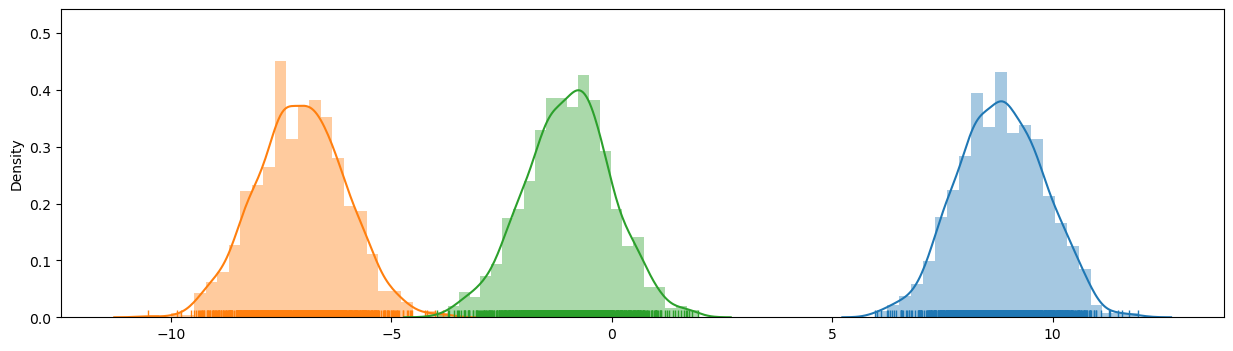

In [9]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.distplot(X[:SAMPLE], ax=ax, rug=True)
sns.distplot(X[SAMPLE:SAMPLE*2], ax=ax, rug=True)
sns.distplot(X[SAMPLE*2:], ax=ax, rug=True)


In [14]:
ugmm = UGMM(X, 3)
ugmm.fit()


Init mean
[16.64811258 -2.40518105  0.88395463]
Init s2
[0.37807453 0.383255   0.7438521 ]
5 [ 8.81039334 -7.05635516 -0.99488657]
10 [ 8.81039334 -7.0575555  -0.99600584]
ELBO converged with ll -1499.498 at iteration 12


In [15]:
sorted(mu_arr)


In [16]:
sorted(ugmm.m)


/tmp/ipykernel_170935/3232548636.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X[:SAMPLE], ax=ax, hist=True, norm_hist=True)
/tmp/ipykernel_170935/3232548636.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.random.normal(
/tmp/ipykernel_170935/3232548636.py:5: UserWarning: 


<AxesSubplot:ylabel='Density'>

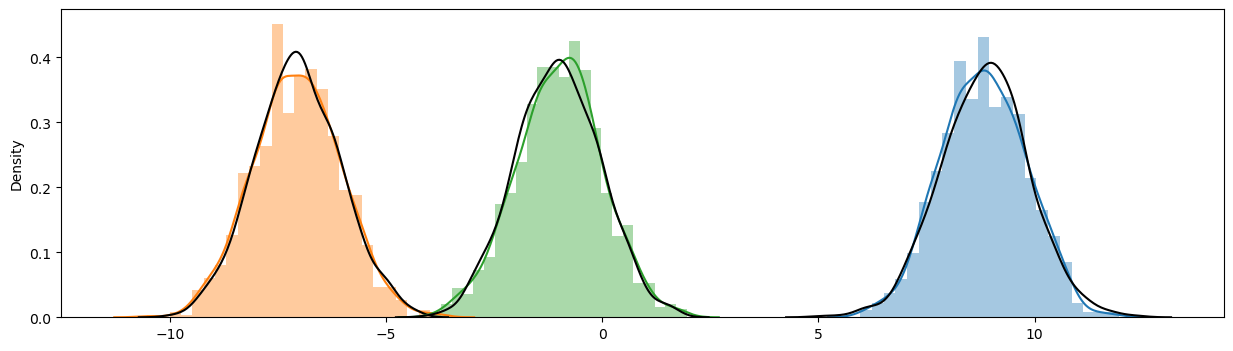

In [17]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.distplot(X[:SAMPLE], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(
    ugmm.m[0], 1, SAMPLE), color='k', hist=False, kde=True)
sns.distplot(X[SAMPLE:SAMPLE*2], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(
    ugmm.m[1], 1, SAMPLE), color='k', hist=False, kde=True)
sns.distplot(X[SAMPLE*2:], ax=ax, hist=True, norm_hist=True)
sns.distplot(np.random.normal(
    ugmm.m[2], 1, SAMPLE), color='k', hist=False, kde=True)


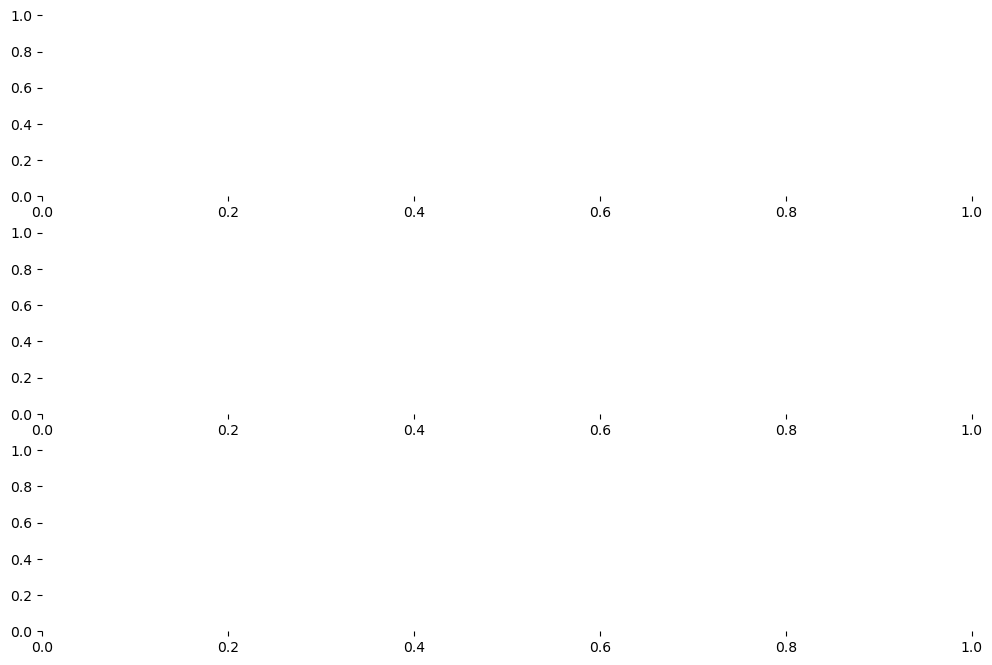

Optimizing covariance parameters...
Log marginal likelihood -21.45470755613295


<Figure size 640x480 with 0 Axes>

Log marginal likelihood -7.134469544598616


<Figure size 640x480 with 0 Axes>

Log marginal likelihood -3.5475811499350307


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 1.4119374521093917


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 7.06834341618146


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 8.101490778964429


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 8.813907359829571


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 11.740968976952644


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 15.99695574673062


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 19.059070504600783


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 21.38620398676116


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 22.522780950303343


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 23.550386946736015


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 25.03024103001286


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 26.328691695469377


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 26.634227386311583


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 27.688587211364357


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 28.347752550038262


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 29.685850917480437


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 31.173437263101995


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 33.692682756254385


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 34.90187987574053


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 35.93199618812231


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 36.299346696934876


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 36.749055448686434


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 36.800706660757314


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 36.872431979221574


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 36.95075448372492


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 37.64593155730458


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 39.164460138838976


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 42.03975257775509


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 46.36866467787327


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 47.10632851546195


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 47.37188987114824


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 47.64985122446572


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 47.726212364826765


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 48.07744300055313


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 48.261687774282294


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 48.31988664703532


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 48.38959387792135


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 48.53355867860902


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 48.64215849656067


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 48.787836218299894


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 48.85076618405397


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 48.91157205760778


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 49.02322589045227


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 49.13471965064692


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 49.42006052953823


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 49.52048093771756


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 49.76850267468882


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 49.804096321048654


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 49.89738078280969


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 50.00540472445615


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 50.05236234570293


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 50.07848701526664


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 50.139334815723316


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 50.20268803610974


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 50.3732110889349


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 50.48952523711628


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 50.62505397625557


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 50.77042776183346


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 50.85435177457771


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 50.95813646468682


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 51.03233498099714


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 51.0464198791441


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 51.11489773592632


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 51.198680772200035


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 51.232220389530944


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 51.27392861348099


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 51.331590824048476


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 51.372731886036554


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 51.393295658306606


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 51.522312659025395


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 51.592448798330636


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 51.61863468495411


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 51.684361915528854


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 51.89034598384648


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 52.03448437352891


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 52.281039426460225


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 52.35394800137366


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 52.478554945539734


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 52.71348744239105


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 52.98439477098462


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 54.02873476559401


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 54.32765768471519


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 54.58163022805727


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 54.648209684641245


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 54.710587087781256


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 54.73450885211532


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 54.758792322551116


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 54.7901334640103


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 54.82495506068369


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 54.90648162831717


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 55.238935344040435


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 55.487407447264125


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 56.0199940464355


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 56.805143877808575


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 57.36806827552721


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 57.42395552981791


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 57.615671977581144


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 57.63316071477663


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 57.665007483010385


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 57.72220228764925


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 57.75562651723787


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 57.783382487293686


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 57.81543153027424


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 57.853660513970034


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 57.92699246190693


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 57.99756169506466


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 58.240921426685034


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 58.544859089057276


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 58.852892512409746


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 59.03059427445609


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 59.22071689893971


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 59.3033697611232


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 59.3543432912319


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 59.383957075877774


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 59.423798218486084


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 59.44210999850718


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 59.45579780681601


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 59.47389806252957


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 59.50951035142456


<Figure size 640x480 with 0 Axes>

Log marginal likelihood 59.52984905338144


KeyboardInterrupt: 

In [6]:
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt

import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import value_and_grad
from scipy.optimize import minimize

def build_step_function_dataset(D=1, n_data=40, noise_std=0.1):
    rs = npr.RandomState(0)
    inputs  = np.linspace(-2, 2, num=n_data)
    targets = np.sign(inputs) + rs.randn(n_data) * noise_std
    inputs  = inputs.reshape((len(inputs), D))
    return inputs, targets


def build_deep_gp(input_dimension, hidden_dimension, covariance_function):

    # GP going from input to hidden
    num_params_layer1, predict_layer1, log_marginal_likelihood_layer1 = \
        make_gp_funs(covariance_function, num_cov_params=input_dimension + 1)

    # GP going from hidden to output
    num_params_layer2, predict_layer2, log_marginal_likelihood_layer2 = \
        make_gp_funs(covariance_function, num_cov_params=hidden_dimension + 1)

    num_hidden_params = hidden_dimension * n_data
    total_num_params = num_params_layer1 + num_params_layer2 + num_hidden_params

    def unpack_all_params(all_params):
        layer1_params = all_params[:num_params_layer1]
        layer2_params = all_params[num_params_layer1:num_params_layer1+num_params_layer2]
        hiddens = all_params[num_params_layer1 + num_params_layer2:]
        return layer1_params, layer2_params, hiddens

    def combined_predict_fun(all_params, X, y, xs):
        layer1_params, layer2_params, hiddens = unpack_all_params(all_params)
        h_star_mean, h_star_cov = predict_layer1(layer1_params, X, hiddens, xs)
        y_star_mean, y_star_cov = predict_layer2(layer2_params, np.atleast_2d(hiddens).T, y, np.atleast_2d(h_star_mean).T)
        return y_star_mean, y_star_cov

    def log_marginal_likelihood(all_params):
        layer1_params, layer2_params, h = unpack_all_params(all_params)
        return log_marginal_likelihood_layer1(layer1_params, X, h) + \
               log_marginal_likelihood_layer2(layer2_params, np.atleast_2d(h).T, y)

    predict_layer_funcs = [predict_layer1, predict_layer2]

    return total_num_params, log_marginal_likelihood, combined_predict_fun, unpack_all_params, \
           predict_layer_funcs


if __name__ == '__main__':

    n_data = 20
    input_dimension = 1
    hidden_dimension = 1
    X, y = build_step_function_dataset(D=input_dimension, n_data=n_data)

    total_num_params, log_marginal_likelihood, combined_predict_fun, unpack_all_params, predict_layer_funcs = \
        build_deep_gp(input_dimension, hidden_dimension, rbf_covariance)

    # Set up figure.
    fig = plt.figure(figsize=(12,8), facecolor='white')
    ax_end_to_end = fig.add_subplot(311, frameon=False)
    ax_x_to_h = fig.add_subplot(312, frameon=False)
    ax_h_to_y = fig.add_subplot(313, frameon=False)
    plt.show(block=False)

    def plot_gp(ax, X, y, pred_mean, pred_cov, plot_xs):
        ax.cla()
        marg_std = np.sqrt(np.diag(pred_cov))
        ax.plot(plot_xs, pred_mean, 'b')
        ax.fill(np.concatenate([plot_xs, plot_xs[::-1]]),
                np.concatenate([pred_mean - 1.96 * marg_std,
                               (pred_mean + 1.96 * marg_std)[::-1]]),
                alpha=.15, fc='Blue', ec='None')

        # Show samples from posterior.
        rs = npr.RandomState(0)
        sampled_funcs = rs.multivariate_normal(pred_mean, pred_cov, size=10)
        ax.plot(plot_xs, sampled_funcs.T)
        ax.plot(X, y, 'kx')
        ax.set_ylim([-1.5, 1.5])
        ax.set_xticks([])
        ax.set_yticks([])

    def callback(params):
        print("Log marginal likelihood {}".format(log_marginal_likelihood(params)))

        # Show posterior marginals.
        plot_xs = np.reshape(np.linspace(-5, 5, 300), (300,1))
        pred_mean, pred_cov = combined_predict_fun(params, X, y, plot_xs)
        plot_gp(ax_end_to_end, X, y, pred_mean, pred_cov, plot_xs)
        ax_end_to_end.set_title("X to y")

        layer1_params, layer2_params, hiddens = unpack_all_params(params)
        h_star_mean, h_star_cov = predict_layer_funcs[0](layer1_params, X, hiddens, plot_xs)
        y_star_mean, y_star_cov = predict_layer_funcs[0](layer2_params, np.atleast_2d(hiddens).T, y, plot_xs)

        plot_gp(ax_x_to_h, X, hiddens,                  h_star_mean, h_star_cov, plot_xs)
        ax_x_to_h.set_title("X to hiddens")

        plot_gp(ax_h_to_y, np.atleast_2d(hiddens).T, y, y_star_mean, y_star_cov, plot_xs)
        ax_h_to_y.set_title("hiddens to y")

        plt.draw()
        plt.pause(1.0/60.0)

    # Initialize covariance parameters and hiddens.
    rs = npr.RandomState(0)
    init_params = 0.1 * rs.randn(total_num_params)

    print("Optimizing covariance parameters...")
    objective = lambda params: -log_marginal_likelihood(params)
    cov_params = minimize(value_and_grad(objective), init_params, jac=True,
                          method='CG', callback=callback)
    plt.pause(10.0)

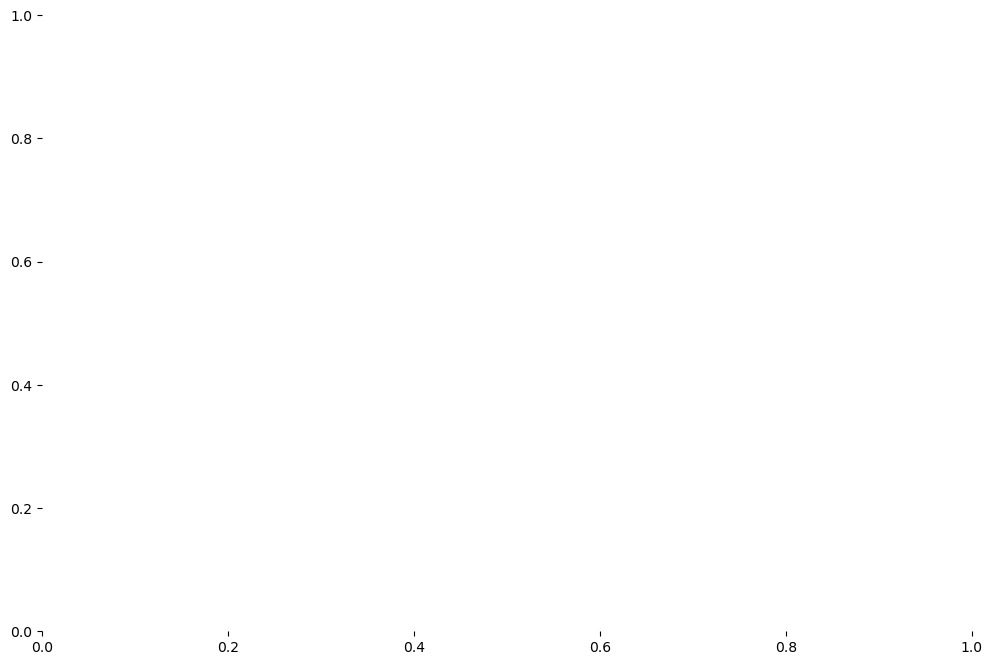

Optimizing covariance parameters...
Log likelihood 9.805252240729983


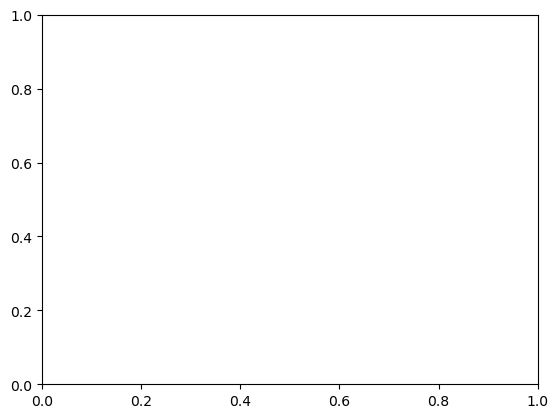

Log likelihood 17.682114335846393


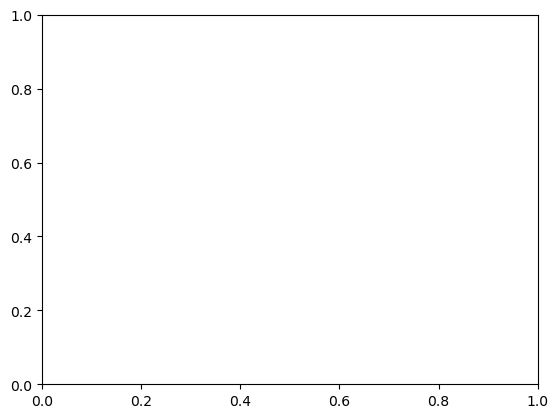

Log likelihood 18.16730523813763


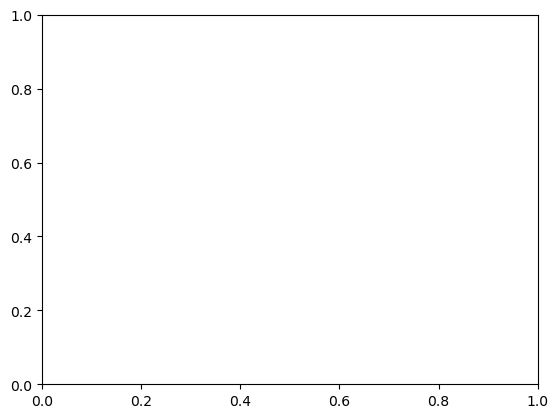

Log likelihood 18.729814009344032


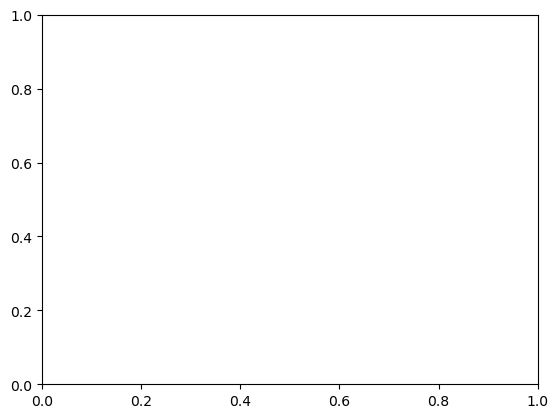

Log likelihood 18.755118594202962


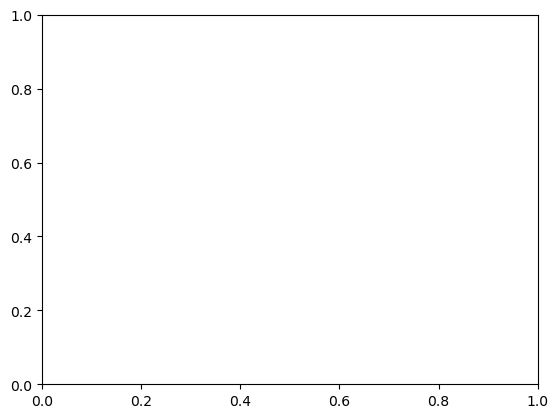

Log likelihood 18.864941820611428


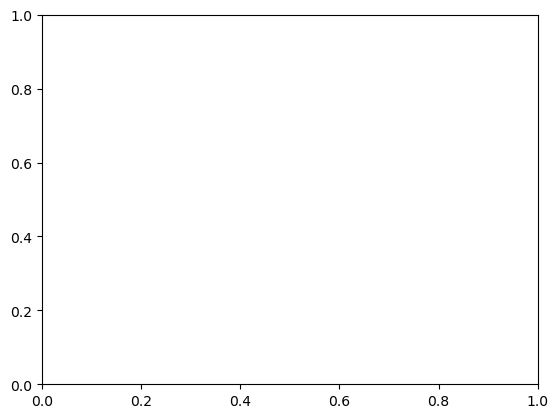

Log likelihood 18.87706078427596


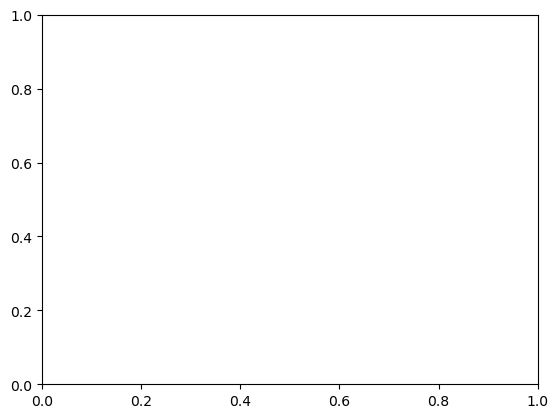

Log likelihood 18.90159165376088


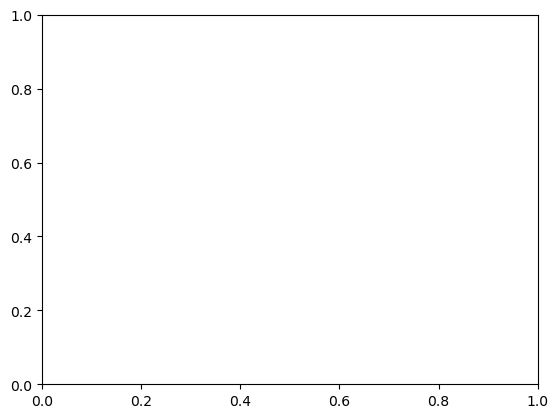

Log likelihood 18.903748881596808


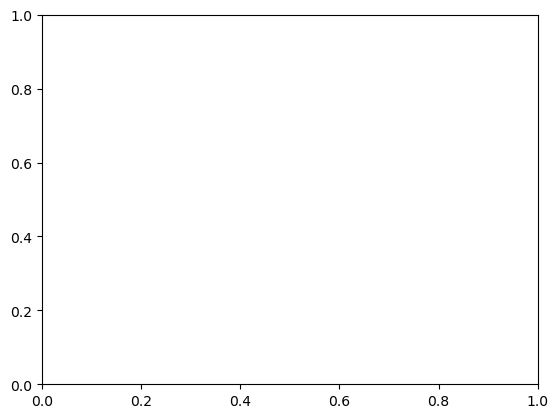

Log likelihood 18.90470342713405


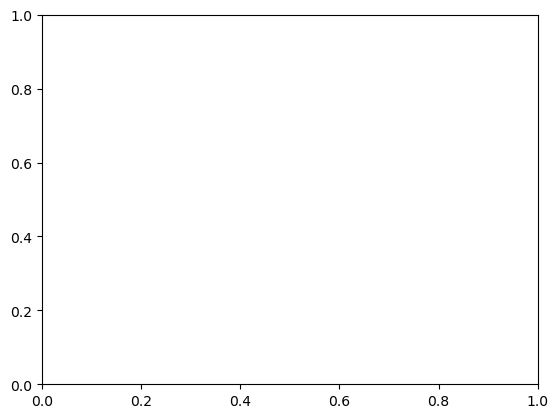

Log likelihood 18.904863126585543


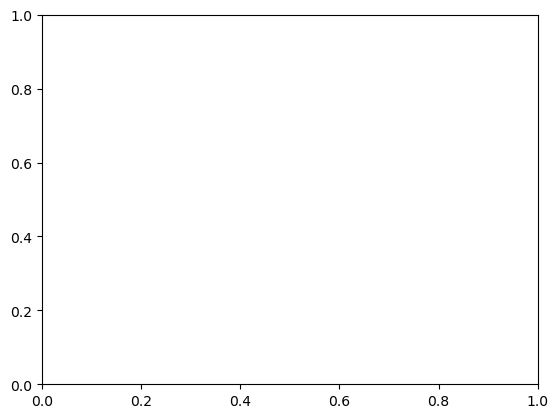

Log likelihood 18.904870536436995


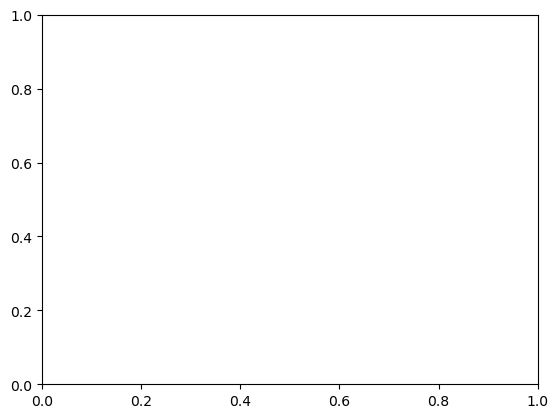

Log likelihood 18.904886849198697


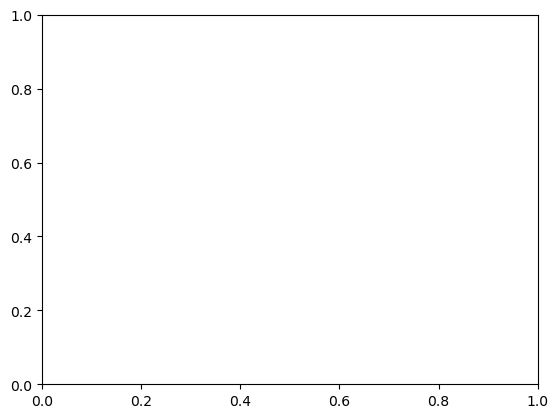

Log likelihood 18.90488995885164


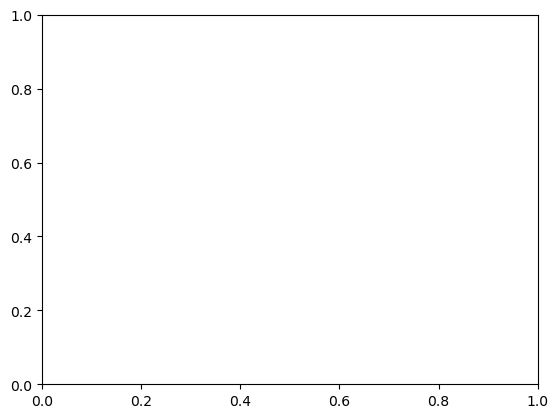

Log likelihood 18.90490471156049


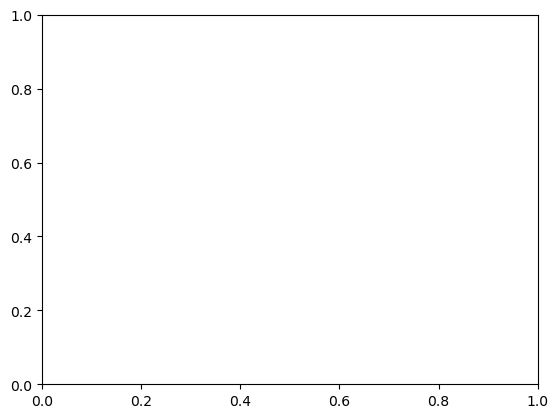

Log likelihood 18.904904716763014


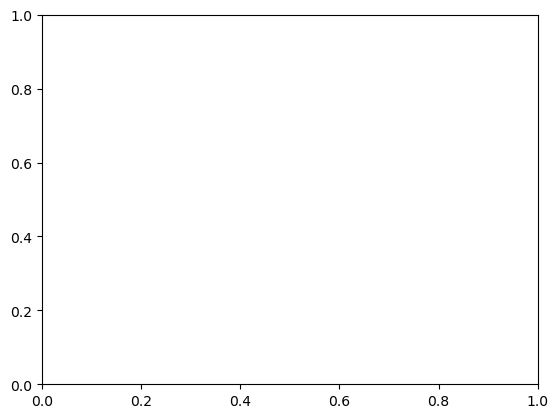

Log likelihood 18.904904717154686


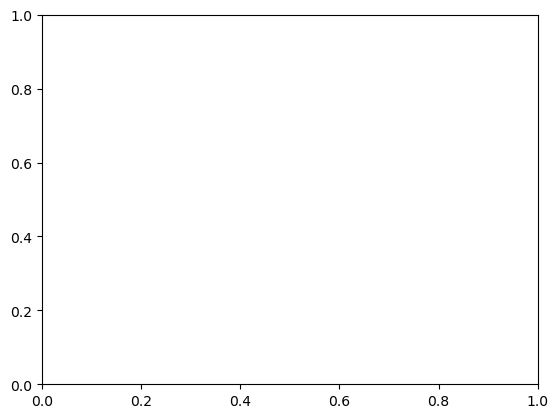

Log likelihood 18.90490471723431


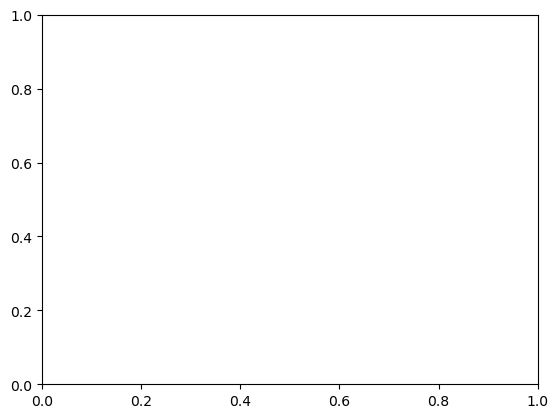

Log likelihood 18.90490471732225


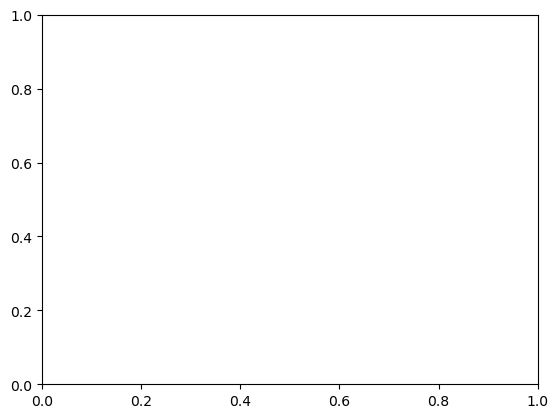

Log likelihood 18.904904717355727


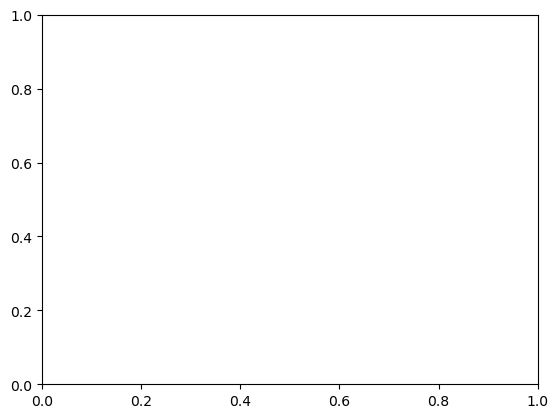

In [11]:
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt

import autograd.numpy as np
import autograd.numpy.random as npr
from autograd.numpy.linalg import solve
import autograd.scipy.stats.multivariate_normal as mvn
from autograd import value_and_grad
from scipy.optimize import minimize


def make_gp_funs(cov_func, num_cov_params):
    """Functions that perform Gaussian process regression.
       cov_func has signature (cov_params, x, x')"""

    def unpack_kernel_params(params):
        mean = params[0]
        cov_params = params[2:]
        noise_scale = np.exp(params[1]) + 0.0001
        return mean, cov_params, noise_scale

    def predict(params, x, y, xstar):
        """Returns the predictive mean and covariance at locations xstar,
           of the latent function value f (without observation noise)."""
        mean, cov_params, noise_scale = unpack_kernel_params(params)
        cov_f_f = cov_func(cov_params, xstar, xstar)
        cov_y_f = cov_func(cov_params, x, xstar)
        cov_y_y = cov_func(cov_params, x, x) + noise_scale * np.eye(len(y))
        pred_mean = mean + np.dot(solve(cov_y_y, cov_y_f).T, y - mean)
        pred_cov = cov_f_f - np.dot(solve(cov_y_y, cov_y_f).T, cov_y_f)
        return pred_mean, pred_cov

    def log_marginal_likelihood(params, x, y):
        mean, cov_params, noise_scale = unpack_kernel_params(params)
        cov_y_y = cov_func(cov_params, x, x) + noise_scale * np.eye(len(y))
        prior_mean = mean * np.ones(len(y))
        return mvn.logpdf(y, prior_mean, cov_y_y)

    return num_cov_params + 2, predict, log_marginal_likelihood

# Define an example covariance function.


def rbf_covariance(kernel_params, x, xp):
    output_scale = np.exp(kernel_params[0])
    lengthscales = np.exp(kernel_params[1:])
    diffs = np.expand_dims(x / lengthscales, 1)\
        - np.expand_dims(xp/lengthscales, 0)
    return output_scale * np.exp(-0.5 * np.sum(diffs**2, axis=2))


def build_toy_dataset(D=1, n_data=20.0, noise_std=0.1):
    rs = npr.RandomState(0)
    inputs = np.concatenate([np.linspace(0, 3, num=10),
                             np.linspace(6, 8, num=10)])
    targets = (np.cos(inputs) + rs.randn(20) * noise_std) / 2.0
    inputs = (inputs - 4.0) / 2.0
    inputs = inputs.reshape((len(inputs), D))
    return inputs, targets


if __name__ == '__main__':

    D = 1

    # Build model and objective function.
    num_params, predict, log_marginal_likelihood = \
        make_gp_funs(rbf_covariance, num_cov_params=D + 1)

    X, y = build_toy_dataset(D=D)
    def objective(params): return -log_marginal_likelihood(params, X, y)

    # Set up figure.
    fig = plt.figure(figsize=(12, 8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    plt.show(block=False)

    def callback(params):
        print("Log likelihood {}".format(-objective(params)))
        plt.cla()

        # Show posterior marginals.
        plot_xs = np.reshape(np.linspace(-7, 7, 300), (300, 1))
        pred_mean, pred_cov = predict(params, X, y, plot_xs)
        marg_std = np.sqrt(np.diag(pred_cov))
        ax.plot(plot_xs, pred_mean, 'b')
        ax.fill(np.concatenate([plot_xs, plot_xs[::-1]]),
                np.concatenate([pred_mean - 1.96 * marg_std,
                               (pred_mean + 1.96 * marg_std)[::-1]]),
                alpha=.15, fc='Blue', ec='None')

        # Show samples from posterior.
        rs = npr.RandomState(0)
        sampled_funcs = rs.multivariate_normal(pred_mean, pred_cov, size=10)
        ax.plot(plot_xs, sampled_funcs.T)

        ax.plot(X, y, 'kx')
        ax.set_ylim([-1.5, 1.5])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.draw()
        plt.pause(1.0/60.0)

    # Initialize covariance parameters
    rs = npr.RandomState(0)
    init_params = 0.1 * rs.randn(num_params)

    print("Optimizing covariance parameters...")
    cov_params = minimize(value_and_grad(objective), init_params, jac=True,
                          method='CG', callback=callback)
    plt.pause(10.0)


In [21]:
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt

import autograd.numpy as np
import autograd.numpy.random as npr
from autograd.numpy.linalg import solve
import autograd.scipy.stats.multivariate_normal as mvn
from autograd import value_and_grad
from scipy.optimize import minimize


def make_gp_funs(cov_func, num_cov_params):
    """Functions that perform Gaussian process regression.
       cov_func has signature (cov_params, x, x')"""

    def unpack_kernel_params(params):
        mean = params[0]
        cov_params = params[2:]
        noise_scale = np.exp(params[1]) + 0.0001
        return mean, cov_params, noise_scale

    def predict(params, x, y, xstar):
        """Returns the predictive mean and covariance at locations xstar,
           of the latent function value f (without observation noise)."""
        mean, cov_params, noise_scale = unpack_kernel_params(params)
        cov_f_f = cov_func(cov_params, xstar, xstar)
        cov_y_f = cov_func(cov_params, x, xstar)
        cov_y_y = cov_func(cov_params, x, x) + noise_scale * np.eye(len(y))
        pred_mean = mean + np.dot(solve(cov_y_y, cov_y_f).T, y - mean)
        pred_cov = cov_f_f - np.dot(solve(cov_y_y, cov_y_f).T, cov_y_f)
        return pred_mean, pred_cov

    def log_marginal_likelihood(params, x, y):
        mean, cov_params, noise_scale = unpack_kernel_params(params)
        cov_y_y = cov_func(cov_params, x, x) + noise_scale * np.eye(len(y))
        prior_mean = mean * np.ones(len(y))
        return mvn.logpdf(y, prior_mean, cov_y_y)

    return num_cov_params + 2, predict, log_marginal_likelihood

# Define an example covariance function.


def rbf_covariance(kernel_params, x, xp):
    output_scale = np.exp(kernel_params[0])
    lengthscales = np.exp(kernel_params[1:])
    diffs = np.expand_dims(x / lengthscales, 1)\
        - np.expand_dims(xp/lengthscales, 0)
    return output_scale * np.exp(-0.5 * np.sum(diffs**2, axis=2))


def build_toy_dataset(D=1, n_data=20, noise_std=0.1):
    rs = npr.RandomState(0)
    inputs = np.concatenate([np.linspace(0, 3, num=n_data/2),
                             np.linspace(6, 8, num=n_data/2)])
    targets = (np.cos(inputs) + rs.randn(n_data) * noise_std) / 2.0
    inputs = (inputs - 4.0) / 2.0
    inputs = inputs.reshape((len(inputs), D))
    return inputs, targets


if __name__ == '__main__':

    D = 1

    # Build model and objective function.
    num_params, predict, log_marginal_likelihood = \
        make_gp_funs(rbf_covariance, num_cov_params=D + 1)

    X, y = build_toy_dataset(D=D)
    def objective(params): return -log_marginal_likelihood(params, X, y)

    # Set up figure.
    fig = plt.figure(figsize=(12, 8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    plt.show(block=False)

    def callback(params):
        print("Log likelihood {}".format(-objective(params)))
        plt.cla()

        # Show posterior marginals.
        plot_xs = np.reshape(np.linspace(-7, 7, 300), (300, 1))
        pred_mean, pred_cov = predict(params, X, y, plot_xs)
        marg_std = np.sqrt(np.diag(pred_cov))
        ax.plot(plot_xs, pred_mean, 'b')
        ax.fill(np.concatenate([plot_xs, plot_xs[::-1]]),
                np.concatenate([pred_mean - 1.96 * marg_std,
                               (pred_mean + 1.96 * marg_std)[::-1]]),
                alpha=.15, fc='Blue', ec='None')

        # Show samples from posterior.
        rs = npr.RandomState(0)
        sampled_funcs = rs.multivariate_normal(pred_mean, pred_cov, size=10)
        ax.plot(plot_xs, sampled_funcs.T)

        ax.plot(X, y, 'kx')
        ax.set_ylim([-1.5, 1.5])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.draw()
        plt.pause(1.0/60.0)

    # Initialize covariance parameters
    rs = npr.RandomState(0)
    init_params = 0.1 * rs.randn(num_params)

    print("Optimizing covariance parameters...")
    cov_params = minimize(value_and_grad(objective), init_params, jac=True,
                          method='CG', callback=callback)
    plt.pause(10.0)


TypeError: 'float' object cannot be interpreted as an integer